# K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ initialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information about cuDF, refer to the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable).

For additional information on cuML's k-means implementation: https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans.

## Imports

In [1]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

## Define Parameters

In [2]:
n_samples = 100000
n_features = 25

n_clusters = 8
random_state = 0

## Generate Data

In [3]:
device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std=0.1
)

In [4]:
# Copy CuPy arrays from GPU memory to host memory (NumPy arrays).
# This is done to later compare CPU and GPU results.
host_data = device_data.get()
host_labels = device_labels.get()

## Scikit-learn model

### Fit

In [5]:
kmeans_sk = skKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    random_state=random_state
)
%timeit kmeans_sk.fit(host_data)

1.44 s ± 74.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## cuML Model

### Fit

In [6]:
kmeans_cuml = cuKMeans(
    init="k-means||",
    n_clusters=n_clusters,
    random_state=random_state
)

%timeit kmeans_cuml.fit(device_data)

10.1 ms ± 98.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means||`. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: This is visualizing the centroids in only two dimensions. 

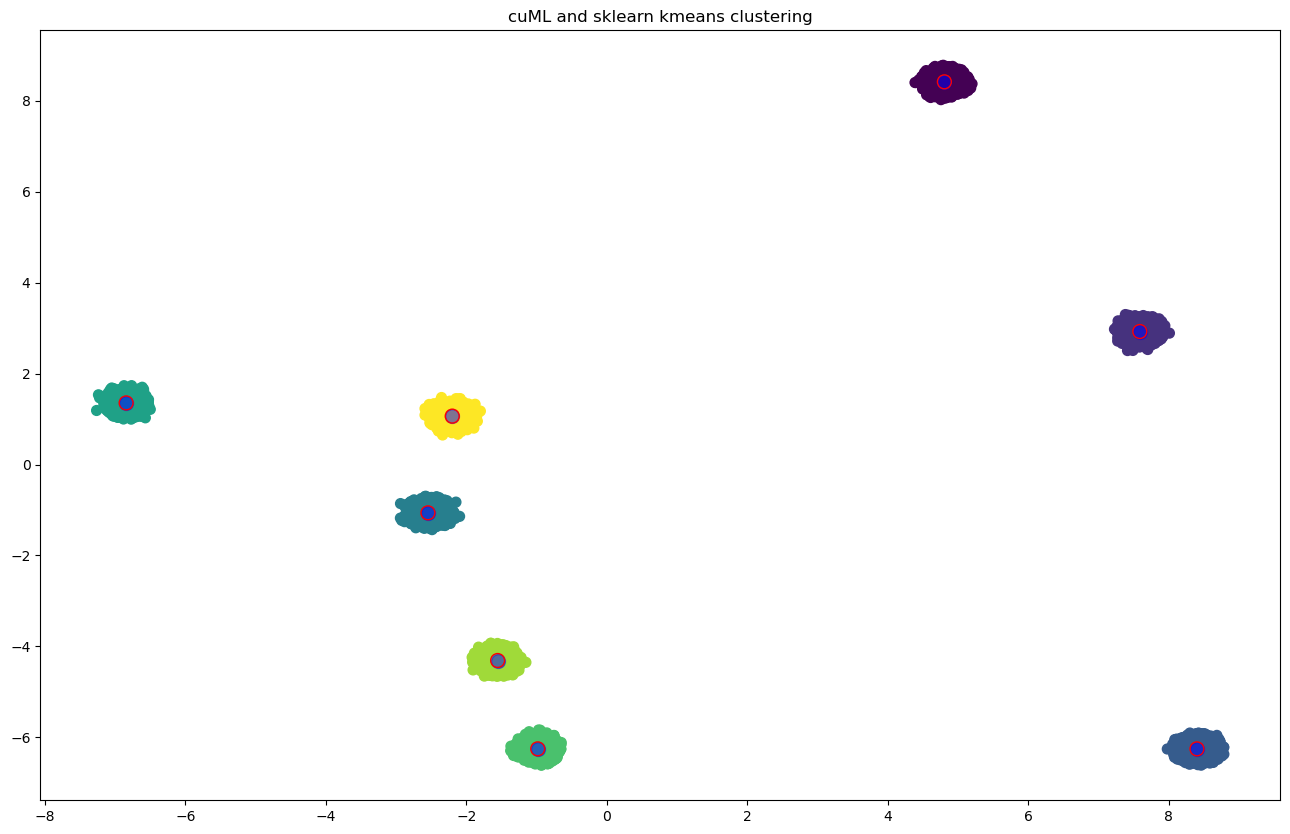

In [7]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:, 0], host_data[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[:, 0]), 
            cupy.asnumpy(centers_cuml[:, 1]), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuML and sklearn kmeans clustering')

plt.show()

## Compare Results

In [8]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.get())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 24.7 ms, sys: 4.36 ms, total: 29 ms
Wall time: 27.6 ms


In [9]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal
